In [4]:


#import all neccessary library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
import xgboost as xgb
import time


In [5]:
# Load the dataset and check for NaNs
df = pd.read_csv('creditcard.csv')

print("Missing values per column:")
print(df.isnull().sum())


Missing values per column:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [6]:
# Step 3: Prepare features and scale 'Amount'

# Drop the 'Class' column from df to get features, and make a copy to avoid SettingWithCopyWarning
X = df.drop('Class', axis=1).copy()

# Extract the target variable (fraud label)
y = df['Class'].values

# Initialize a StandardScaler to scale 'Amount' feature to have mean=0 and std=1
scaler = StandardScaler()

# Fit the scaler on 'Amount' column and transform it, replacing original 'Amount' in X
X['Amount'] = scaler.fit_transform(X[['Amount']])

# Verify that there are no NaN values introduced after scaling
print("Any NaNs in features after scaling?", X.isnull().values.any())


Any NaNs in features after scaling? False


In [7]:
RND = 42  # Define random seed

# Step 4: Train/test split with stratification to maintain class balance

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RND
)

print("NaNs in y_train?", np.isnan(y_train).any())
print("NaNs in y_test?", np.isnan(y_test).any())


NaNs in y_train? False
NaNs in y_test? False


In [8]:
# Step 5: Define resampling methods to handle class imbalance

sampling_pipelines = {
    'No Sampling': None,  # Train on original data without any resampling
    'RandomUnderSampler': RandomUnderSampler(random_state=RND),  # Randomly reduce majority class
    'SMOTE': SMOTE(random_state=RND),  # Synthetic Minority Oversampling Technique
    'ADASYN': ADASYN(random_state=RND),  # Adaptive Synthetic sampling
    'TomekLinks': TomekLinks(),  # Undersampling using Tomek Links cleaning
    'SMOTE+Tomek': SMOTETomek(random_state=RND)  # Combination of SMOTE and Tomek Links
}

# Step 6: Define fixed XGBoost model parameters for fair comparison

model_params = {
    'n_estimators': 200,
    'max_depth': 4,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    # Removed 'use_label_encoder' to avoid warnings in recent xgboost versions
    'eval_metric': 'logloss',
    'random_state': RND
}


In [9]:
# Step 7: Train and evaluate XGBoost models with each sampling method
results = []       # To store performance metrics for each method
models = {}        # To keep trained models (for ROC curves later)
y_probas = {}      # To keep predicted probabilities for ROC curves

for name, sampler in sampling_pipelines.items():
    print(f"\n=== Sampling Method: {name} ===")

    # Copy train data before resampling
    X_tr, y_tr = X_train.copy(), y_train.copy()

    start_time = time.time()

    if sampler is not None:
        # For TomekLinks and SMOTE+Tomek, use smaller sample to speed up
        if name in ['TomekLinks', 'SMOTE+Tomek']:
            print(f"Using smaller sample (10,000 rows) for {name} due to slowness...")
            sample_idx = np.random.choice(len(X_tr), size=10000, replace=False)
            X_small, y_small = X_tr.iloc[sample_idx], y_tr[sample_idx]

            print(f"Starting resampling with {name} on smaller data...")
            X_res, y_res = sampler.fit_resample(X_small, y_small)
            print(f"Completed resampling with {name}.")
        else:
            print(f"Starting resampling with {name}...")
            X_res, y_res = sampler.fit_resample(X_tr, y_tr)
            print(f"Completed resampling with {name}.")

        y_res = y_res.astype(int)
    else:
        X_res, y_res = X_tr, y_tr

    print(f"Resampled training class distribution: {np.bincount(y_res)}")

    # Initialize and train the XGBoost classifier
    model = xgb.XGBClassifier(**model_params)
    model.fit(X_res, y_res)

    train_time = time.time() - start_time

    # Predict on the test set
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Calculate evaluation metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

    # Save results for comparison
    results.append({
        'Method': name,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'AUC': auc,
        'TrainTimeSec': train_time,
        'TP': int(cm[1, 1]),
        'FP': int(cm[0, 1]),
        'FN': int(cm[1, 0]),
        'TN': int(cm[0, 0])
    })

    # Store model and probabilities for later plotting
    models[name] = model
    y_probas[name] = y_proba

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}, Train Time: {train_time:.2f}s")



=== Sampling Method: No Sampling ===
Resampled training class distribution: [227451    394]
Precision: 0.9205, Recall: 0.8265, F1: 0.8710, AUC: 0.9764, Train Time: 8.12s

=== Sampling Method: RandomUnderSampler ===
Starting resampling with RandomUnderSampler...
Completed resampling with RandomUnderSampler.
Resampled training class distribution: [394 394]
Precision: 0.0390, Recall: 0.9184, F1: 0.0748, AUC: 0.9775, Train Time: 0.34s

=== Sampling Method: SMOTE ===
Starting resampling with SMOTE...
Completed resampling with SMOTE.
Resampled training class distribution: [227451 227451]
Precision: 0.2659, Recall: 0.8980, F1: 0.4103, AUC: 0.9798, Train Time: 16.07s

=== Sampling Method: ADASYN ===
Starting resampling with ADASYN...
Completed resampling with ADASYN.
Resampled training class distribution: [227451 227593]
Precision: 0.2596, Recall: 0.8980, F1: 0.4027, AUC: 0.9790, Train Time: 13.76s

=== Sampling Method: TomekLinks ===
Using smaller sample (10,000 rows) for TomekLinks due to s


Results summary:
                Method  Precision    Recall        F1       AUC
1  RandomUnderSampler   0.038961  0.918367  0.074751  0.977459
2               SMOTE   0.265861  0.897959  0.410256  0.979794
3              ADASYN   0.259587  0.897959  0.402746  0.979038
0         No Sampling   0.920455  0.826531  0.870968  0.976363
5         SMOTE+Tomek   0.601562  0.785714  0.681416  0.964879
4          TomekLinks   0.817204  0.775510  0.795812  0.949286


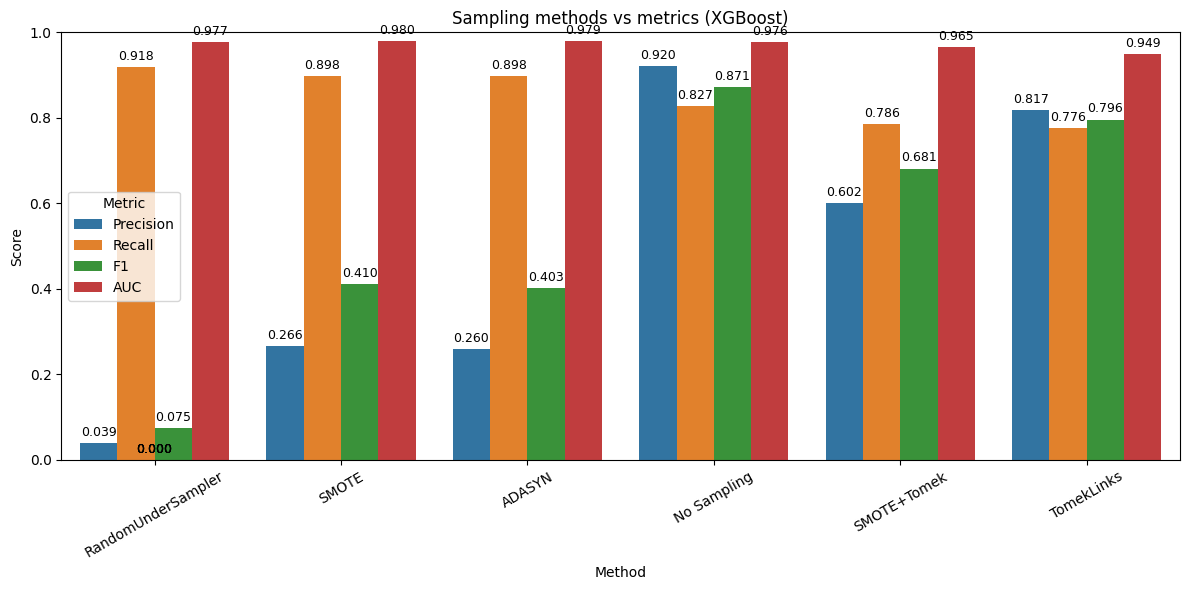

<Figure size 800x600 with 0 Axes>

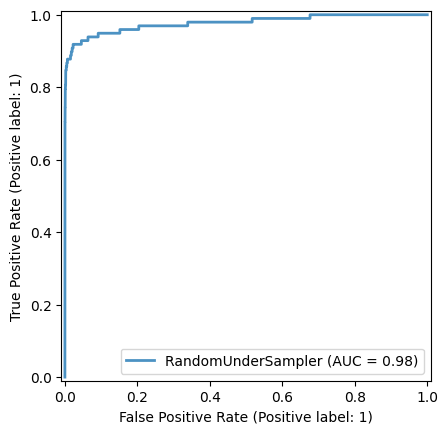

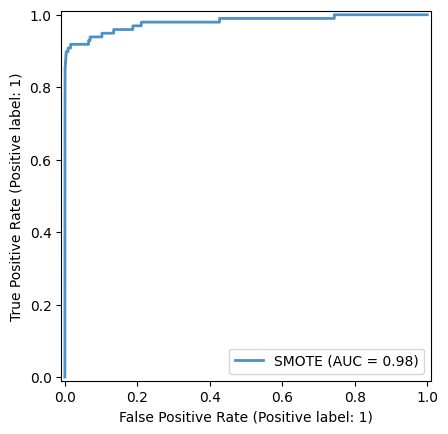

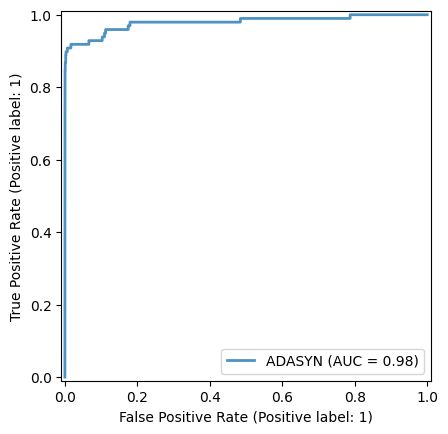

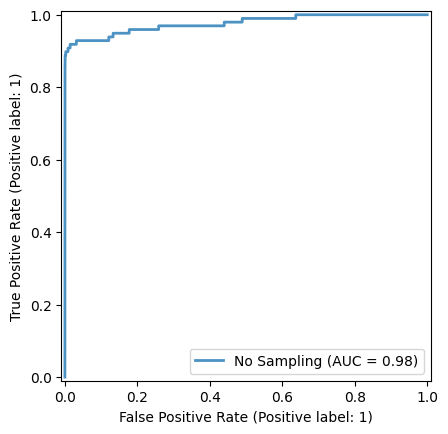

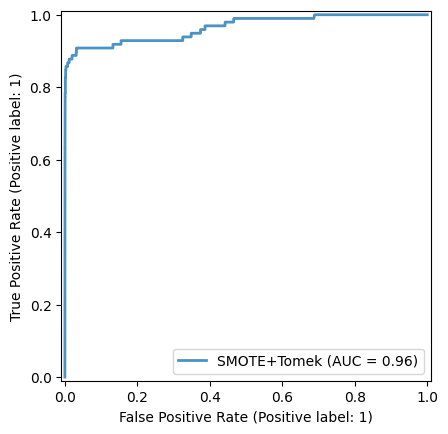

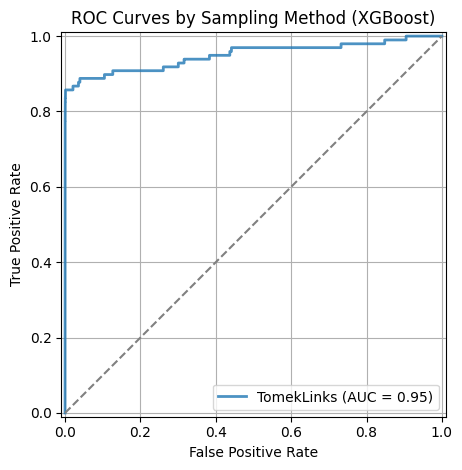

In [10]:
# Convert results list to DataFrame and sort by Recall
res_df = pd.DataFrame(results).sort_values(by='Recall', ascending=False)

print("\nResults summary:\n", res_df[['Method','Precision','Recall','F1','AUC']])

# Plot grouped bar chart of Precision, Recall, F1, AUC
metrics_melt = res_df.melt(id_vars='Method', value_vars=['Precision','Recall','F1','AUC'],
                          var_name='Metric', value_name='Score')

plt.figure(figsize=(12,6))
ax = sns.barplot(data=metrics_melt, x='Method', y='Score', hue='Metric')

for p in ax.patches:
    ax.annotate(f"{p.get_height():.3f}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=9, xytext=(0,3), textcoords='offset points')

plt.ylim(0,1)
plt.xticks(rotation=30)
plt.title("Sampling methods vs metrics (XGBoost)")
plt.tight_layout()
plt.show()

# Plot ROC curves for all methods
plt.figure(figsize=(8,6))
for name in res_df['Method']:
    RocCurveDisplay.from_predictions(y_test, y_probas[name], name=name, alpha=0.8, lw=2)

plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.title("ROC Curves by Sampling Method (XGBoost)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
import pandas as pd

# Create summary DataFrame sorted by Recall descending
res_df = pd.DataFrame(results).sort_values(by='Recall', ascending=False)

# Select columns to display
summary_table = res_df[['Method', 'Precision', 'Recall', 'F1', 'AUC', 'TrainTimeSec', 'TP', 'FP', 'FN', 'TN']]

# Display the table nicely (especially in Jupyter)
display(summary_table.style.format({
    'Precision': '{:.4f}',
    'Recall': '{:.4f}',
    'F1': '{:.4f}',
    'AUC': '{:.4f}',
    'TrainTimeSec': '{:.2f}'
}))


,Method,Precision,Recall,F1,AUC,TrainTimeSec,TP,FP,FN,TN
1,RandomUnderSampler,0.0390,0.9184,0.0748,0.9775,0.34,90,2220,8,54644
2,SMOTE,0.2659,0.8980,0.4103,0.9798,16.07,88,243,10,56621
3,ADASYN,0.2596,0.8980,0.4027,0.9790,13.76,88,251,10,56613
0,No Sampling,0.9205,0.8265,0.8710,0.9764,8.12,81,7,17,56857
5,SMOTE+Tomek,0.6016,0.7857,0.6814,0.9649,4.21,77,51,21,56813
4,TomekLinks,0.8172,0.7755,0.7958,0.9493,1.00,76,17,22,56847
